# applying extreme value theory using pyextremes

In [2]:
import requests 
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime

import pyextremes as pyext
from pyextremes.plotting import plot_extremes

import matplotlib.pyplot as plt
%matplotlib inline

## extracting time series from netcdf file

In [3]:
ds = xr.open_dataset("./data/pr_Amon_NorESM1-M_historical_r1i1p1_185001-200512.nc")
print(ds)

<xarray.Dataset>
Dimensions:    (time: 1872, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/26)
    institution:            Norwegian Climate Centre
    institute_id:           NCC
    experiment_id:          historical
    source:                 NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Oslo-n...
    model_id:               NorESM1-M
    forcing:                GHG, SA, Oz, Sl, Vl, BC, OC
    ...                     ...
    table_id:               Table Amon (27 April 2011) a5a1c518f52ae340313ba0...
    title:                  NorESM1-M mo

In [4]:
# converting precipitation to m/day units

ds["pr"].data = ds["pr"].data * 86.4
ds["pr"].attrs["units"] = 'm/day' 

In [5]:
# setting defined location
# coordinates for berkeley, california

lat = 37.87
lon = 122.27

In [6]:
# getting dataset specifically for defined location

ds_berk = ds.sel(lon=lon, lat=lat, method='nearest')

In [7]:
ds_berk['pr'].values

array([0.00017749, 0.00060158, 0.00168481, ..., 0.00080042, 0.00033764,
       0.00064344], dtype=float32)

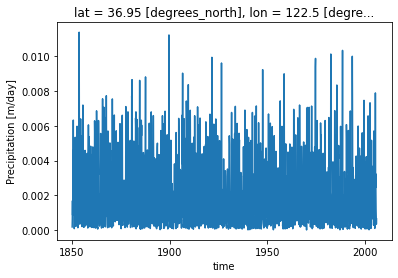

In [8]:
# plotting values for defined location

ds_berk['pr'].plot()

In [9]:
# converting to timeseries

series = ds_berk['pr'].to_pandas()

In [10]:
series.index = series.index.to_datetimeindex()

/var/folders/bz/l7frggbx71n9k19wxh7hvwsm0000gn/T/ipykernel_31099/2564721491.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  series.index = series.index.to_datetimeindex()


## block maxima (bm) approach

### using standalone process

In [11]:
extremes = pyext.get_extremes(
    ts=series,
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
    min_last_block=None,
)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='date-time', ylabel='extreme values'>)

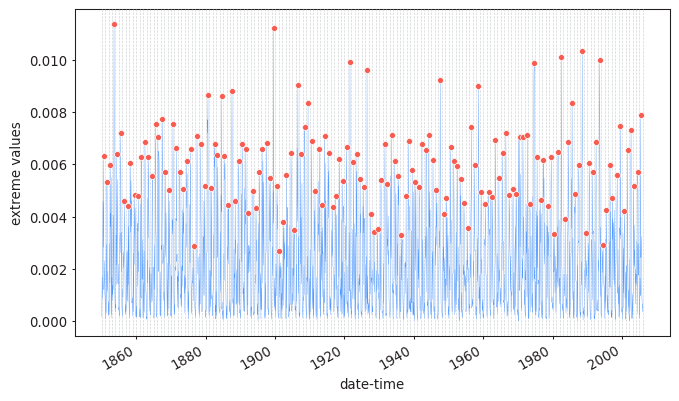

In [12]:
plot_extremes(
    ts=series,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
)

### using extreme value analysis (eva)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='date-time', ylabel='extreme values'>)

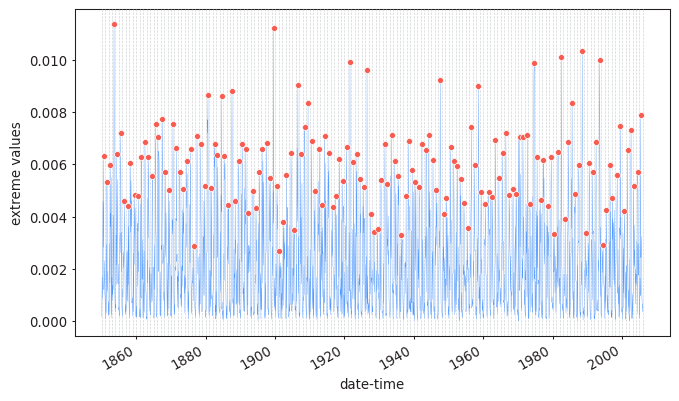

In [13]:
model = pyext.EVA(data=series)
model.get_extremes("BM")
model.plot_extremes()

### using a 2 year block size (using eva)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='date-time', ylabel='extreme values'>)

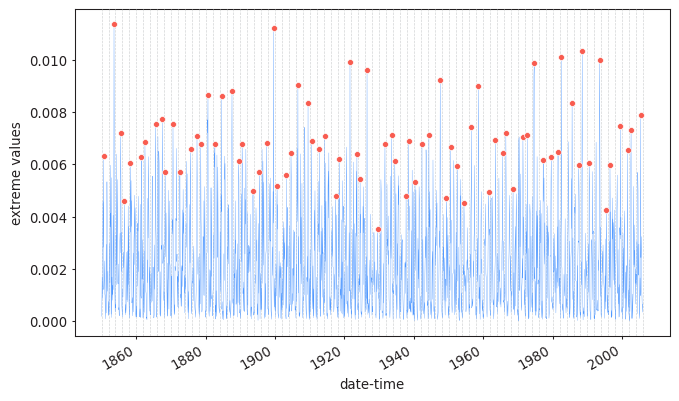

In [14]:
model = pyext.EVA(data=series)
model.get_extremes("BM", block_size=pd.to_timedelta("365.2425D") * 2)
model.plot_extremes()

## peak over threshold (pot) approach

### using standalone process

In [15]:
# note: r set to 3D (3 days) given that heavy precipitation events can last longer than a day

extremes = pyext.get_extremes(
    ts=series,
    method="POT",
    extremes_type="high",
    threshold=0.005,
    r="3D"
)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='date-time', ylabel='extreme values'>)

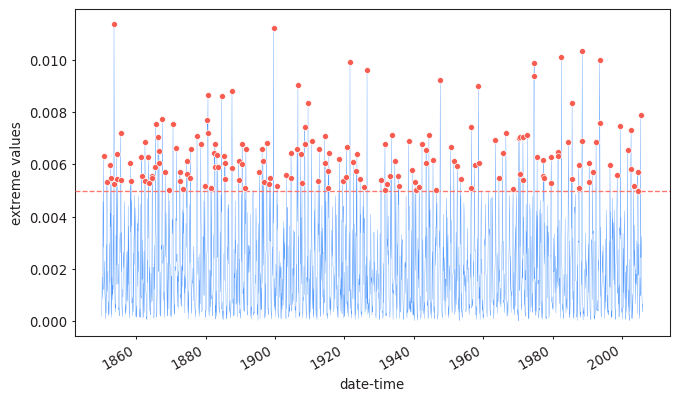

In [16]:
plot_extremes(
    ts=series,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    threshold=0.005,
    r="3D"
)

### using extreme value analysis (eva)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='date-time', ylabel='extreme values'>)

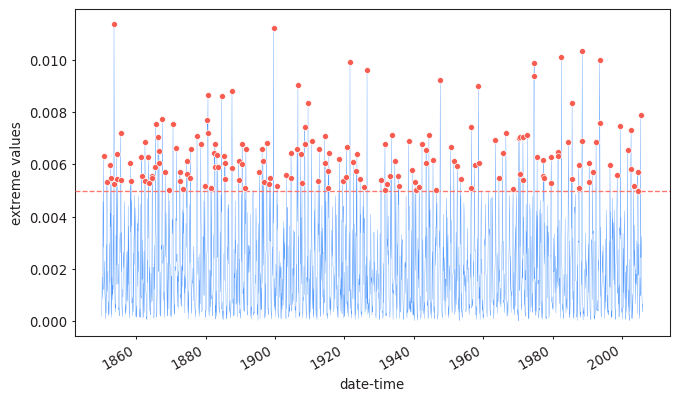

In [17]:
# note: r set to 48H given that heavy precipitation events can last longer than a day

model = pyext.EVA(data=series)
model.get_extremes("POT", threshold=0.005, r="3D")
model.plot_extremes(show_clusters=True)

## threshold selection

### mean residual life

<AxesSubplot:xlabel='Threshold', ylabel='Mean excess'>

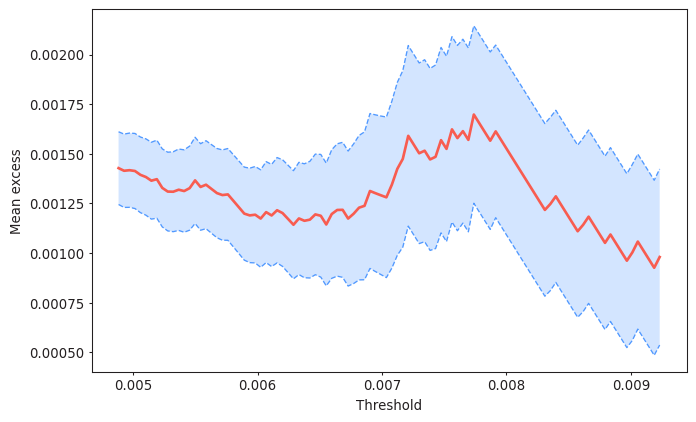

In [18]:
# mean residual life plot should be approximately linear above a threshold
# find the range of threshold values which can be investigated further

pyext.plot_mean_residual_life(series)

### paremeter stability

(<AxesSubplot:ylabel='Shape, $\\xi$'>,
 <AxesSubplot:xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

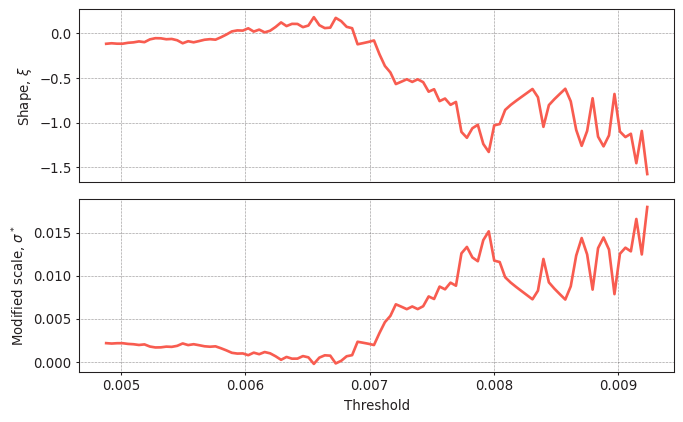

In [19]:
# parameters should be stable (vary very little) between defined thresholds

pyext.plot_parameter_stability(series)

### return value stability

<AxesSubplot:xlabel='Threshold', ylabel='Return value'>

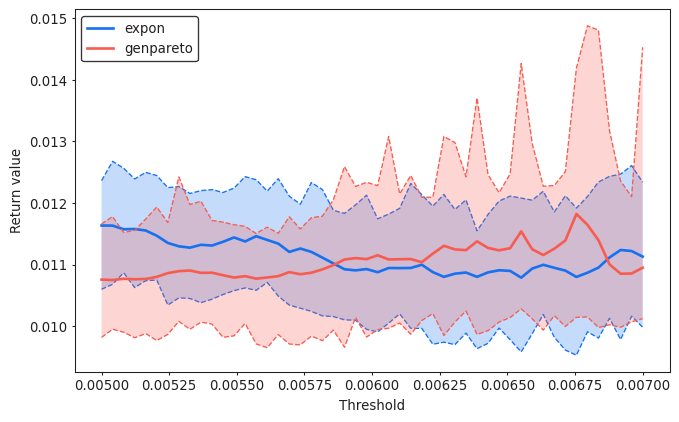

In [20]:
pyext.plot_return_value_stability(
    series,
    return_period=100,
    thresholds=np.linspace(0.005, 0.007),
    alpha=0.95,
)

## from return periods to corresponding return values

### using block maxima (bm)

#### approach 1

In [29]:
# fit time series and convert to EVA class

model = pyext.EVA(series)

In [30]:
# get extremes using 1-year block size
# fit EVA to extremes model

model.get_extremes(method="BM", block_size="365.2425D")
model.fit_model()

In [31]:
# define return period(s)
# get summary of corresponding return values from return periods

return_periods = [2, 5, 10, 25, 50, 100, 250, 500, 1000]

summary = model.get_summary(
    return_period=return_periods,
    alpha=0.95,
    n_samples=1000,
)

In [32]:
print(summary)

               return value  lower ci  upper ci
return period                                  
2.0                0.005804  0.005548  0.006070
5.0                0.007401  0.007035  0.007755
10.0               0.008458  0.007983  0.008901
25.0               0.009794  0.009180  0.010376
50.0               0.010784  0.010071  0.011469
100.0              0.011768  0.010923  0.012560
250.0              0.013063  0.012085  0.013988
500.0              0.014041  0.012945  0.015078
1000.0             0.015018  0.013806  0.016147


#### approach 2

In [ ]:
extremes = pyext.get_extremes(
    ts=series,
    method="BM",
    block_size="365.2425D",
)

return_periods = pyext.get_return_periods(
    ts=series,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
    return_period_size="365.2425D",
    plotting_position="weibull",
)

return_periods.sort_values("return period", ascending=False).head()

### using peak over threshold (pot)

In [26]:
extremes = pyext.get_extremes(
    ts=series,
    method="POT",
    extremes_type="high",
    threshold=0.006,
    r="3D"
)

return_periods = pyext.get_return_periods(
    ts=series,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    return_period_size="365.2425D",
    plotting_position="weibull",
)

return_periods.sort_values("return period", ascending=False).head()

,extreme values,exceedance probability,return period
date-time,,,
1853-08-16 12:00:00,0.011385,0.010309,157.539711
1899-08-16 12:00:00,0.011228,0.020619,78.769856
1988-07-16 12:00:00,0.010341,0.030928,52.513237
1982-07-16 12:00:00,0.010131,0.041237,39.384928
1993-07-16 12:00:00,0.010001,0.051546,31.507942


In [ ]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)